In [1]:
%%capture
%run ch04_linear_algebra.ipynb
%run ch06_probability.ipynb
%run ch18_neural_networks.ipynb

In [2]:
# Tensor (n-dimensional arrays)

Tensor = list # we will just assume a Tensor is a Python list

from typing import List

def shape(tensor: Tensor) -> List[int]:
    sizes: List[int] = []
        
    while isinstance(tensor, list):
        sizes.append(len(tensor)) # number of items (rows)
        tensor = tensor[0]        # consider first item only to get number of columes
        
    return sizes

assert shape([1, 2, 3]) == [3]
assert shape([[1, 2], [3, 4], [5, 6]]) == [3, 2]

In [3]:
def is_1d(tensor: Tensor) -> bool:
    """
    If tensor[0] is a list, it's a higher-order (>=2-dimensional) tensor.
    Otherwise, tensor is 1-dimensional (i.e., vector)
    """
    
    return not isinstance(tensor[0], list)

assert is_1d([1, 2, 3])
assert not is_1d([[1, 2], [3, 4], [5, 6]])

In [4]:
def tensor_sum(tensor: Tensor) -> float:
    """Sums up all the values in the tensor"""
    if is_1d(tensor):
        return sum(tensor) # just a list of floats (vector), use Python sum
    else:
        return sum(tensor_sum(tensor_i)       # Recursively call tensor_sum on each item (row)
                   for tensor_i in tensor)    # and sum up those results

assert tensor_sum([1, 2, 3]) == 6
assert tensor_sum([[1, 2], [3, 4], [5, 6]]) == 3 + 7 + 11 == 21    

In [5]:
from typing import Callable

def tensor_apply(f: Callable[[float], float], tensor: Tensor) -> Tensor:
    """Applies f elementwise"""
    if is_1d(tensor):
        return [f(x) for x in tensor]
    else:
        return [tensor_apply(f, tensor_i)     # Recursive call tensor_apply on each item (row) 
                for tensor_i in tensor]
    
assert tensor_apply(lambda x: x + 1, [1, 2, 3]) == [2, 3, 4]
assert tensor_apply(lambda x: 2 * x, [[1, 2], [3, 4], [5, 6]]) == [[2, 4], [6, 8], [10, 12]]

In [6]:
def zeros_like(tensor: Tensor) -> Tensor:
    return tensor_apply(lambda _: 0.0, tensor)

assert zeros_like([1, 2, 3]) == [0, 0, 0]
assert zeros_like([[1, 2], [3, 4], [5, 6]]) == [[0, 0], [0, 0], [0, 0]] 

In [7]:
import operator

def tensor_combine(f: Callable[[float, float], float], 
                   t1: Tensor, 
                   t2: Tensor) -> Tensor:
    """Applies f to corresponding elements of t1 and t2"""
    if is_1d(t1):
        return [f(x, y) for x, y in zip(t1, t2)] # assume t1 and t2 have the same shape
    
    else:
        return [tensor_combine(f, t1_i, t2_i)    # recursive call again
                for t1_i, t2_i in zip(t1, t2)]

assert tensor_combine(operator.add, [1, 2, 3], [4, 5, 6]) == [5, 7, 9]
assert tensor_combine(operator.mul, [1, 2, 3], [4, 5, 6]) == [4, 10, 18]

In [8]:
# The Layer abstraction

from typing import Iterable, Tuple

class Layer:
    """
    Our neural networks will be composed of Layers, each of which
    knows how to do some computation on its inputs in the "forward"
    direction and propagate gradients in the "backward" direction.
    """
    
    def forward(self, input):
        """
        Note the lack of types. We're not going to be prescriptive
        about what kinds of input layers can take and what kinds
        of outputs they can return.
        """
        raise NotImplementedError
        
    def backward(self, gradient):
        """
        Similarly, we're not going to be prescriptive about what the 
        gradient looks like. It's up to you the user to make sure 
        that you're doing things sensibly.
        """
        raise NotImplementedError
        
    def params(self) -> Iterable[Tensor]:
        """
        Returns the parameters of this layer. The default implementation
        returns nothing, so that if you have a layer with no parameters
        you don't have to implement this.
        """
        return ()

    def grads(self) -> Iterable[Tensor]:
        """
        Returns the gradients, in the same order as params().
        """
        return ()

In [9]:
# Specific Layer - Sigmoid

class Sigmoid(Layer):
    
    def forward(self, input: Tensor) -> Tensor:
        """
        Apply sigmoid to each element of the input tensor,
        and save the results to use in backpropagation.
        """
        self.sigmoids = tensor_apply(sigmoid, input)
        return self.sigmoids
    
    def backward(self, gradient: Tensor) -> Tensor:
        
        return tensor_combine(lambda sig, grad: sig * (1 - sig) * grad, 
                              self.sigmoids, 
                              gradient)

In [10]:
# Specific Layer - Linear

import random

def random_uniform(*dims: int) -> Tensor:
    if len(dims) == 1:
        return [random.random() for _ in range(dims[0])]
    else:
        return [random_uniform(*dims[1:]) for _ in range(dims[0])]
    
def random_normal(*dims: int, 
                  mean: float = 0.0, 
                  variance: float = 1.0) -> Tensor:
    if len(dims) == 1:
        return [mean + variance * inverse_normal_cdf(random.random()) 
                for _ in range(dims[0])]
    else:
        return [random_normal(*dims[1:], mean=mean, variance=variance) 
                for _ in range(dims[0])]
    
assert shape(random_uniform(2, 3, 4)) == [2, 3, 4]
assert shape(random_normal(5, 6, mean=10)) == [5, 6]

In [11]:
def random_tensor(*dims: int, init: str = 'normal') -> Tensor:
    if init == 'normal':                # choose weights from a standard normal distribution
        return random_normal(*dims)
    elif init == 'uniform':             # choose weights from a random uniform distribution
        return random_uniform(*dims)
    elif init == 'xavier':              # choose weights from a normal distribution with mean 0 and variance 2 / (num_inputs + num_outputs)
        variance = len(dims) / sum(dims)
        return random_normal(*dims, variance=variance)
    else:
        raise ValueError(f"unknown init: {init}")

In [12]:
class Linear(Layer):
    def __init__(self, 
                 input_dim: int, 
                 output_dim: int, 
                 init: str = 'xavier') -> None:
    
        """
        A layer of output_dim neurons, each with input_dim weights (and a bias)
        """
        self.input_dim = input_dim
        self.output_dim = output_dim

        # self.w[o] is the weights for the oth neuron
        self.w = random_tensor(output_dim, input_dim, init=init)

        # self.b[o] is the bias term for the oth neuron
        self.b = random_tensor(output_dim, init=init)
    
    def forward(self, input: Tensor) -> Tensor:
        # Save the input to use in the backward pass
        self.input = input
        
        # Return the vector of neuron outputs
        return [dot(input, self.w[o]) + self.b[o] 
                for o in range(self.output_dim)]
    
    def backward(self, gradient: Tensor) -> Tensor:
        # Each b[o] gets added to output[o], which means
        # the gradient of b is the same as the output gradient
        self.b_grad = gradient
        
        # Each w[o][i] multiplies input[i] and gets added to output[o]
        # So its gradient is input[i] * gradient[o]
        self.w_grad = [[self.input[i] * gradient[o] 
                        for i in range(self.input_dim)] 
                       for o in range(self.output_dim)]
        
        # Each input[i] multiplies every w[o][i] and gets added tp every
        # output[o]. So, its gradient is the sum of w[o][i] * gradient[o]
        # across all the outputs
        return [sum(self.w[o][i] * gradient[o] for o in range(self.output_dim)) 
                for i in range(self.input_dim)]
    
    def params(self) -> Iterable[Tensor]:
        return [self.w, self.b]
    
    def grads(self) -> Iterable[Tensor]:
        return [self.w_grad, self.b_grad]

In [13]:
# Specific Layer - Sequential

from typing import List

class Sequential(Layer):
    """
    A layer consisting of a sequence of other layers.
    It's up to you to make sure that the output of each layer
    makes sense as the input to the next layer.
    """
    
    def __init__(self, layers: List[Layer]) -> None:
        self.layers = layers
        
    def forward(self, input):
        """Just forward the input through the layers in order"""
        for layer in self.layers:
            input = layer.forward(input) # recursive call
        
        return input
    
    def backward(self, gradient):
        """Just backpropagate the gradient through the layers in reverse"""
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient) # recursive call
        
        return gradient
    
    def params(self) -> Iterable[Tensor]:
        """Just return the params from each layer"""
        
        return (param 
                for layer in self.layers 
                for param in layer.params())
    
    def grads(self) -> Iterable[Tensor]:
        """Just return the grads from each layer"""
        
        return (grad 
                for layer in self.layers 
                for grad in layer.grads())    

In [14]:
# XOR network
xor_net = Sequential([
    Linear(input_dim=2, output_dim=2), 
    Sigmoid(), 
    Linear(input_dim=2, output_dim=1), 
    Sigmoid()
])

In [15]:
# Loss

class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        """How good are our predictions?"""
        raise NotImplementedError
    
    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        """How does the loss change as the predictions change?"""
        raise NotImplementedError

In [16]:
# Loss: Sum of Squared Errors

class SSE(Loss):
    """Loss function that computes the sum of the squared errors"""
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # Compute the tensor of squared differences
        squared_errors = tensor_combine(lambda predicted, actual: (predicted - actual) ** 2, 
                                        predicted, 
                                        actual)
        # And just add them up
        return tensor_sum(squared_errors)
    
    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return tensor_combine(lambda predicted, actual: 2 * (predicted - actual), 
                              predicted, 
                              actual)

In [17]:
# Optimizer

class Optimizer:
    """
    An optimizer updates the weights of a layer (in place) using information
    known by either the layer or the optimizer (or by both)
    """
    
    def step(self, layer: Layer) -> None:
        raise NotImplementedError

In [18]:
# Optimizer: Gradient Descent

class GradientDescent(Optimizer):
    def __init__(self, learning_rate: float = 0.1) -> None:
        self.lr = learning_rate
        
    def step(self, layer: Layer) -> None:
        for param, grad in zip(layer.params(), layer.grads()):
            # Update param using a gradient step
            param[:] = tensor_combine(lambda param, grad: param - grad * self.lr, # update parameters
                                      param, 
                                      grad)

In [19]:
# Optimizer: Momentum

class Momentum(Optimizer):
    def __init__(self, 
                 learning_rate: float, 
                 momentum: float = 0.9) -> None:
        
        self.lr = learning_rate
        self.mo = momentum
        self.updates: List[Tensor] = [] # running averages
            
    def step(self, layer: Layer) -> None:
        # If we have no previous updates, start with all zeros
        if not self.updates:
            self.updates = [zeros_like(grad) for grad in layer.grads()]
        
        for update, param, grad in zip(self.updates, 
                                       layer.params(), 
                                       layer.grads()):
            # Apply momentum
            update[:] = tensor_combine(lambda u, g: self.mo * u + (1 - self.mo) * g, 
                                       update, 
                                       grad)
            
            # Then take a gradient step
            param[:] = tensor_combine(lambda p, u: p - self.lr * u, 
                                      param, 
                                      update)

In [20]:
# XOR training

xs = [[0., 0], [0., 1], [1., 0], [1., 1]]
ys = [[0.], [1.], [1.], [0.]]

net = Sequential([
    Linear(input_dim=2, output_dim=2), 
    Sigmoid(), 
    Linear(input_dim=2, output_dim=1) 
])

import tqdm

optimizer = GradientDescent(learning_rate=0.1)
loss = SSE()

with tqdm.trange(3000) as t:
    for epoch in t:
        epoch_loss = 0.0
        
        for x, y in zip(xs, ys):
            predicted = net.forward(x)
            epoch_loss += loss.loss(predicted, y)
            gradient = loss.gradient(predicted, y)
            net.backward(gradient)
            
            optimizer.step(net)
        
        t.set_description(f"xor loss {epoch_loss:.3f}")

xor loss 0.000: 100%|█████████████████████████████████████████████████████████████| 3000/3000 [00:04<00:00, 656.76it/s]


In [21]:
for param in net.params():
    print(param)

[[-1.4819010685580585, -1.5549866815335935], [-3.5479156170676847, -4.083924186792363]]
[1.7625509925192948, 0.4315803257787224]
[[3.252398787096746, -3.410897253573463]]
[-0.7081564723558701]


In [22]:
# Other activation functions

import math

def tanh(x: float) -> float:
    # If x is very large or very small, tanh is essentially 1 or -1.
    # We check for this because, e.g., math.exp(1000) raises an error.
    if x < -100:  return -1
    elif x > 100: return 1
    
    em2x = math.exp(-2 * x)
    return (1 - em2x) / (1 + em2x)

class Tanh(Layer):
    def forward(self, input: Tensor) -> Tensor:
        # Save tanh output to use in backward pass
        self.tanh = tensor_apply(tanh, input)
        return self.tanh
    
    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(
            lambda tanh, grad: (1 - tanh ** 2) * grad, 
            self.tanh, 
            gradient)
    
class Relu(Layer):
    def forward(self, input: Tensor) -> Tensor:
        self.input = input
        return tensor_apply(lambda x: max(x, 0), input)
    
    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(
            lambda x, grad: grad if x > 0 else 0, 
            self.input, 
            gradient)

In [23]:
# FizzBuzz training

xs = [binary_encode(n) for n in range(101, 1024)]
ys = [fizz_buzz_encode(n) for n in range(101, 1024)]

NUM_HIDDEN = 25

random.seed(0)

net = Sequential([
    Linear(input_dim=10, output_dim=NUM_HIDDEN, init='uniform'), 
    Tanh(),
    Linear(input_dim=NUM_HIDDEN, output_dim=4, init='uniform'),
    Sigmoid()
])

In [24]:
def fizzbuzz_accuracy(low: int, hi: int, net: Layer) -> float:
    num_correct = 0
    
    for n in range(low, hi):
        x = binary_encode(n)
        predicted = argmax(net.forward(x))
        actual = argmax(fizz_buzz_encode(n))
        
        if predicted == actual:
            num_correct += 1
    
    return num_correct / (hi - low)

optimizer = Momentum(learning_rate=0.1, momentum=0.9)
loss = SSE()

with tqdm.trange(1000) as t:
    for epoch in t:
        epoch_loss = 0.0
        
        for x, y in zip(xs, ys):
            predicted = net.forward(x)
            epoch_loss += loss.loss(predicted, y)
            gradient = loss.gradient(predicted, y)
            net.backward(gradient)
            
            optimizer.step(net)
        
        accuracy = fizzbuzz_accuracy(101, 1024, net)
        t.set_description(f"fb loss: {epoch_loss:.2f} acc: {accuracy:.2f}")

print("test results", fizzbuzz_accuracy(1, 101, net))

fb loss: 64.54 acc: 0.95: 100%|████████████████████████████████████████████████████| 1000/1000 [11:15<00:00,  1.48it/s]

test results 0.9


In [25]:
# Softmaxes and Cross-Entropy (Negative Log Likelihood)

def softmax(tensor: Tensor) -> Tensor:
    """Softmax along the last dimension"""
    
    if is_1d(tensor):
        # Subtract the largest value for numerical stability
        largest = max(tensor)
        exps = [math.exp(x - largest) for x in tensor]
        
        sum_of_exps = sum(exps)        # This is the total weight
        return [exp_i / sum_of_exps    # Probability is the fraction of the total weight
                for exp_i in exps]
    else:
        return [softmax(tensor_i) for tensor_i in tensor] # recursive call
    
class SoftmaxCrossEntropy(Loss):
    """
    This is the negative-log-likelihood of the observed values, given the
    neural net model. So, if we choose weights to minimize it, our model will
    be maximizing the likelihood of the observed data.
    """
    
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # Apply softmax to get probabilities
        probabilities = softmax(predicted)
        
        # This will be log p_i for the actual class i and 0 for the other classes
        # We add a tiny amount to p to avoid taking log(0)
        likelihoods = tensor_combine(lambda p, act: math.log(p + 1e-30) * act, 
                                     probabilities, 
                                     actual)
        
        # And then we just sum up the negatives
        return -tensor_sum(likelihoods)
    
    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        
        probabilities = softmax(predicted)
        
        return tensor_combine(lambda p, actual: p - actual, 
                              probabilities, 
                              actual)

In [26]:
random.seed(0)

net = Sequential([
    Linear(input_dim=10, output_dim=NUM_HIDDEN, init='uniform'), 
    Tanh(),
    Linear(input_dim=NUM_HIDDEN, output_dim=4, init='uniform'),
    # No final Sigmoid layer here
])

optimizer = Momentum(learning_rate=0.1, momentum=0.9)
loss = SoftmaxCrossEntropy()

with tqdm.trange(100) as t: # much fewer epochs here
    for epoch in t:
        epoch_loss = 0.0
        
        for x, y in zip(xs, ys):
            predicted = net.forward(x)
            epoch_loss += loss.loss(predicted, y)
            gradient = loss.gradient(predicted, y)
            net.backward(gradient)
            
            optimizer.step(net)
        
        accuracy = fizzbuzz_accuracy(101, 1024, net)
        t.set_description(f"fb loss: {epoch_loss:.2f} acc: {accuracy:.2f}")

print("test results", fizzbuzz_accuracy(1, 101, net))

fb loss: 5.06 acc: 1.00: 100%|███████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.62it/s]

test results 0.97


In [27]:
# Dropout (only during training)

class Dropout(Layer):
    def __init__(self, p: float) -> None:
        self.p = p
        self.train = True # to indicate the training phase
    
    def forward(self, input: Tensor) -> Tensor:
        if self.train:
            # Create a mask of 0s and 1s shaped like the input
            # using the spcified probability
            self.mask = tensor_apply(lambda _: 0 if random.random() < self.p else 1, 
                                     input)
            
            # Multiply by the mask to dropout inputs
            return tensor_combine(operator.mul, input, self.mask)
        else:
            # During evaluation just scale down the outputs uniformly
            return tensor_apply(lambda x: x * (1 - self.p), input)
        
    def backward(self, gradient: Tensor) -> Tensor:
        if self.train:
            # Only propagate the gradients where mask == 1
            return tensor_combine(operator.mul, gradient, self.mask)
        else:
            raise RuntimeError("don't call backward when not in training phase")

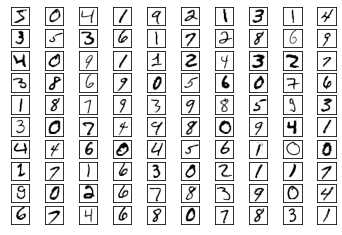

In [28]:
# MNIST (python -m pip install mnist) data download

import mnist
    
# This will download the data, change this to where you want it.
# (Yes, it's a 0-argument function, that's what the library expects.)
# (Yes, I'm assigning a lambda to a variable, like I said never to do.)
mnist.temporary_dir = lambda: 'data\\mnist'

# Each of these functions first downloads the data and returns a numpy array.
# We call .tolist() because our "tensors" are just lists.
train_images = mnist.train_images().tolist()
train_labels = mnist.train_labels().tolist()

assert shape(train_images) == [60000, 28, 28] # 2d images
assert shape(train_labels) == [60000]

import matplotlib.pyplot as plt

fig, ax = plt.subplots(10, 10)

for i in range(10):
    for j in range(10):
        # Plot each image in black and white and hide the axes.
        ax[i][j].imshow(train_images[10 * i + j], cmap='Greys')
        ax[i][j].xaxis.set_visible(False)
        ax[i][j].yaxis.set_visible(False)

plt.show()

In [29]:
test_images = mnist.test_images().tolist()
test_labels = mnist.test_labels().tolist()
    
assert shape(test_images) == [10000, 28, 28]
assert shape(test_labels) == [10000]

In [30]:
# Data pre-processing

# Compute the average pixel value
avg = tensor_sum(train_images) / 60000 / 28 / 28

# Recenter, rescale, and flatten
train_images = [[(pixel - avg) / 256 for row in image for pixel in row]
                for image in train_images]
test_images = [[(pixel - avg) / 256 for row in image for pixel in row]
               for image in test_images]

assert shape(train_images) == [60000, 784], "images should be flattened" # 1d images
assert shape(test_images) == [10000, 784], "images should be flattened"

# After centering, average pixel should be very close to 0
assert -0.0001 < tensor_sum(train_images) < 0.0001

In [31]:
# One-hot encoding

def one_hot_encode(i: int, num_labels: int = 10) -> List[float]:
    return [1.0 if j == i else 0.0 for j in range(num_labels)]

assert one_hot_encode(3) == [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
assert one_hot_encode(2, num_labels=5) == [0, 0, 1, 0, 0]

In [32]:
train_labels = [one_hot_encode(label) for label in train_labels]
test_labels = [one_hot_encode(label) for label in test_labels]

assert shape(train_labels) == [60000, 10]
assert shape(test_labels) == [10000, 10]

In [33]:
# Training loop

import tqdm

def loop(model: Layer, 
         images: List[Tensor], 
         labels: List[Tensor], 
         loss: Loss, 
         optimizer: Optimizer = None) -> None:
    
    correct = 0
    total_loss = 0.0
    
    with tqdm.trange(len(images)) as t:
        for i in t:
            predicted = model.forward(images[i])
            if argmax(predicted) == argmax(labels[i]):
                correct += 1
            total_loss += loss.loss(predicted, labels[i])
            
            # If we're training, backpropagate gradient and update weights
            if optimizer is not None:
                gradient = loss.gradient(predicted, labels[i])
                model.backward(gradient)
                optimizer.step(model)
            
            # And update our metrics in the progress bar
            avg_loss = total_loss / (i + 1)
            acc = correct / (i + 1)
            t.set_description(f"mnist loss: {avg_loss:.3f} acc: {acc:.3f}")

In [34]:
# Logistic Regression

random.seed(0)

# Logistic regression is just a linear layer followed by softmax
model = Linear(784, 10)

loss = SoftmaxCrossEntropy()
optimizer = Momentum(learning_rate=0.01, momentum=0.99)

# Training
loop(model, train_images, train_labels, loss, optimizer)

# Test
loop(model, test_images, test_labels, loss)

mnist loss: 0.361 acc: 0.891: 100%|█████████████████████████████████████████████| 10000/10000 [00:20<00:00, 476.52it/s]


In [35]:
# Deep Neural Network (784-30-10-10)

random.seed(0)

dropout1 = Dropout(0.1)
dropout2 = Dropout(0.1)

model = Sequential([
    Linear(784, 30),     # Hidden layer 1 
    dropout1, 
    Tanh(), 
    Linear(30, 10),      # Hidden layer 2
    dropout2, 
    Tanh(), 
    Linear(10, 10)       # Output layer
])

loss = SoftmaxCrossEntropy()
optimizer = Momentum(learning_rate=0.01, momentum=0.99)

# Enable dropout and train
dropout1.train = dropout2.train = True
loop(model, train_images, train_labels, loss, optimizer)

# Disable dropout and test
dropout1.train = dropout2.train = False
loop(model, test_images, test_labels, loss)

mnist loss: 0.313 acc: 0.908: 100%|█████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.34it/s]


In [36]:
# Saving and Loading Models
import json

def save_weights(model: Layer, filename: str) -> None:
    weights = list(model.params())
    with open(filename, 'w') as f:
        json.dump(weights, f)
        
def load_weights(model: Layer, filename: str) -> None:
    with open(filename) as f:
        weights = json.load(f)
    
    # Check for consistency
    assert all(shape(param) == shape(weight) 
               for param, weight in zip(model.params(), weights))
    
    # Then load using slice assignment
    for param, weight in zip(model.params(), weights):
        param[:] = weight